### **Tweeter sentiment analysis - Singlish**

In [ ]:
!pip install googletrans==3.1.0a0

In [ ]:
# import required libraries
import pandas as pd
import numpy as np
from googletrans import Translator
import matplotlib.pyplot as plt

import re
import string
import nltk
import spacy
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Read the dataset

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/NLP labs/SinglishTweets.csv')

In [ ]:
print(df.shape)
df.head(5)

(1121, 5)


,Index,PublicFigure,Statement,Impact,Unnamed: 4
0,184174P,Abisheka Wimalaweera,සාමාන්‍යයෙන් පෞද්ගලික චරිත ගැන ලියන්න හොද නෑ....,Positive,NaN
1,NaN,Roshan Fernando,මම නුවරඑළියේ ඉදන් කොළඹට ඇවිල්ලා ගායකයෙක් වෙන්න...,Positive,NaN
2,NaN,Rasika Jayakodi,Ego system Vs. Eco system \n\nසාමාන්‍යයෙන් ලංක...,Positive,NaN
3,NaN,Peshala Manoj,අද උදේ දැකපු සුන්දර දර්ශණයක්. නුගේගොඩ St.Johns...,Positive,NaN
4,NaN,Mahinda Deshapriya,"Smoking is a bad habit \nMenda , Danee🏏✌.\nCri...",Positive,NaN


#### Here, we remove unwanted cloumns from the dataset

In [ ]:
# drop unwanted columns
df.drop([' Index', 'PublicFigure', 'Unnamed: 4'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  1119 non-null   object
 1   Impact     1108 non-null   object
dtypes: object(2)
memory usage: 17.6+ KB


In [ ]:
# check for nulls
df.isnull().any()

Statement    True
Impact       True
dtype: bool

In [ ]:
# drop nulls
df.dropna(inplace=True)
df.isnull().any()

Statement    False
Impact       False
dtype: bool

In [ ]:
df.shape

(1108, 2)

#### There were missing values in the dataset. We dropped them. Then labeled positive sentiment as 1, and negetive as 0

In [ ]:
# positive - 1 , negative - 0
df['Impact'] = df['Impact'].apply(lambda x: 1 if x=='Positive' else 0)
df.head()

,Statement,Impact
0,සාමාන්‍යයෙන් පෞද්ගලික චරිත ගැන ලියන්න හොද නෑ....,1
1,මම නුවරඑළියේ ඉදන් කොළඹට ඇවිල්ලා ගායකයෙක් වෙන්න...,1
2,Ego system Vs. Eco system \n\nසාමාන්‍යයෙන් ලංක...,1
3,අද උදේ දැකපු සුන්දර දර්ශණයක්. නුගේගොඩ St.Johns...,1
4,"Smoking is a bad habit \nMenda , Danee🏏✌.\nCri...",1


#### We check the length of available tweets and if the length is too much large compared to the others, we remove them for the simplicity.

In [ ]:
# see the length of sentences
df1 = df.copy()# = df1
df1['length'] = df1['Statement'].apply(lambda x: len(x))
df1.head()

,Statement,Impact,length
0,සාමාන්‍යයෙන් පෞද්ගලික චරිත ගැන ලියන්න හොද නෑ....,1,479
1,මම නුවරඑළියේ ඉදන් කොළඹට ඇවිල්ලා ගායකයෙක් වෙන්න...,1,403
2,Ego system Vs. Eco system \n\nසාමාන්‍යයෙන් ලංක...,1,1095
3,අද උදේ දැකපු සුන්දර දර්ශණයක්. නුගේගොඩ St.Johns...,1,298
4,"Smoking is a bad habit \nMenda , Danee🏏✌.\nCri...",1,91


In [ ]:
df1.length.value_counts()

63       12
75       12
65       11
120      10
111      10
         ..
11182     1
2914      1
603       1
1500      1
240       1
Name: length, Length: 407, dtype: int64

In [ ]:
len(df1[df1.length > 500]) # to be removed

77

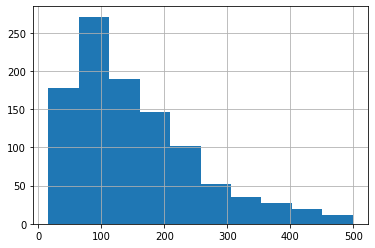

In [ ]:
# filter rows with length less than 500
df1 = df1[df1.length < 500]
df1.reset_index(inplace=True)
df1.length.hist()

In [ ]:
df1.shape

(1031, 4)

#### Finally, take 90% of random data from the dataset. Furthermore, according to the amount of data from two classes, it can be considered as a balance dataset.



In [ ]:
# take random smlple
df1 = df1.sample(frac = 0.9, ignore_index=True)
df1.shape

(928, 4)

In [ ]:
# check for class balance 
df1.Impact.value_counts()

1    468
0    460
Name: Impact, dtype: int64

In [ ]:
# final dataframe
df1.drop(['length','index'], axis=1, inplace=True) 
df1.head()

,Statement,Impact
0,Phone මිල ඉහලට\r\nසමහර ආයතන ලංකාව අතහැර යයි\r\...,0
1,මට නිකන් හිතෙනවා political special එකක් කරන කෙ...,0
2,"මිතුරනි,පුරවැසියනි,\r\nසසිඳු සහන් තාරක ඇතුළු,ස...",0
3,අපි ඉතිං ඩොලර් කාක්කො නේ,0
4,ගාල්ල කොහොමද...? ඔන්න මම එනවා ඔක්තෝබර් 15 ස්පන...,1


### **Text Preprocessing**

In [ ]:
tweets = df1['Statement']
y = df1['Impact']

#### Function to remove emojis

In [ ]:
def remove_emoji(string):
    pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return pattern.sub(r'', string)

We are using a blank spacy pipeline to use as a tokenizer for Sinhala language, **spacy.blank("si")**. Further, remove sinhala stopwords using **token.is_stop**.

Furthermore, below function includes:


*   remove emojis
*   remove numbers, unnessary symbols, tweeter handles (@...), etc
*   remove punctuations





In [ ]:
## function for preprocessing sinhala

nlp = spacy.blank("si")  # for sinhala

def clean_sinhText(tweet):
  # removing urls
  txt = re.sub(r'http\S+', '', tweet)

  # remove emojis
  txt = remove_emoji(txt)

  # remove numbers, unnessary symbols, tweeter handles (@...), etc
  txt = re.sub("\d+|\\n|\\r", '', txt)
  txt = re.sub("\/|#", ' ', txt) 
  txt = re.sub("@[A-Za-z0-9_]+","", txt)

  # tokenizing 
  doc = nlp(txt)
  txt = []
  for token in doc:
    if not token.is_stop:  # removing stop words for sinhala
      txt.append(token.text)   
    
  # removing punctuations
  txt = [word for word in txt if word not in string.punctuation]

  # again join words into sentences
  txt = ' '.join(txt)

  return txt

Translate all tweets into English. It is better to convert to a one language before doing word embeddings (used in future steps). becuase sometimes, words with same meaning can be appeared in two languages. 

In [ ]:
translator = Translator()

def convert_eng(tweet):
  txt = translator.translate(tweet, dest="en").text 
  txt = re.sub('[^a-zA-Z]', ' ', txt)
  return txt

When comparing lemmatization and stemming, both have drawbacks with different words. Here, some examples in these tweets.

In [ ]:
# examples
porterStemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

print('Lemmatization\n-------------------')
print("generally :", lemmatizer.lemmatize("generally"))
print("future :", lemmatizer.lemmatize("future"))
print("underestimate :", lemmatizer.lemmatize("underestimate"))
print("entering :", lemmatizer.lemmatize("entering"))

print('\nStemming\n-------------------')
print("generally :", porterStemmer.stem("generally"))
print("future :", porterStemmer.stem("future"))
print("underestimate :", porterStemmer.stem("underestimate"))
print("entering :", porterStemmer.stem("entering"))


Lemmatization
-------------------
generally : generally
future : future
underestimate : underestimate
entering : entering

Stemming
-------------------
generally : gener
future : futur
underestimate : underestim
entering : enter


Below function includes:
*   convert to lower case
*   split the words within a sentence
*   removing english stop words
*   Lemmatization





In [ ]:
lemmatizer = WordNetLemmatizer()

def final_cleanText(tweet):
  tweet = tweet.lower()
  tweet = tweet.split()
  clean_tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in stopwords.words('english')]
  clean_tweet = ' '.join(clean_tweet)
  return clean_tweet

#### Apply above functions to all tweets and then generate the final cleaned corpus

In [ ]:
# for all tweets
corpus = []
for i in range(0, len(tweets)):
  corpus.append(clean_sinhText(tweets[i]))

In [ ]:
clean_corpus = []
for tweet in corpus:
  clean_corpus.append(convert_eng(tweet))

In [ ]:
final_corpus = []
for tweet in clean_corpus:
  final_corpus.append(final_cleanText(tweet))

In [ ]:
final_corpus[:5]

['phone price rise company leaving sri lanka buying phone like dream',
 'think person political special make lot curse make living',
 'dear citizen condemn crackdown sasindu sasindu peaceful protestors justice sasindu others',
 'dollar',
 'galle coming enjoy october pulse concert meet outdoor premise galle municipal council']

Add the clean tweets to the dataframe

In [ ]:
df2 = df1.copy()
df2['clean_tweet'] = final_corpus
df2.head()

,Statement,Impact,clean_tweet
0,Phone මිල ඉහලට\r\nසමහර ආයතන ලංකාව අතහැර යයි\r\...,0,phone price rise company leaving sri lanka buy...
1,මට නිකන් හිතෙනවා political special එකක් කරන කෙ...,0,think person political special make lot curse ...
2,"මිතුරනි,පුරවැසියනි,\r\nසසිඳු සහන් තාරක ඇතුළු,ස...",0,dear citizen condemn crackdown sasindu sasindu...
3,අපි ඉතිං ඩොලර් කාක්කො නේ,0,dollar
4,ගාල්ල කොහොමද...? ඔන්න මම එනවා ඔක්තෝබර් 15 ස්පන...,1,galle coming enjoy october pulse concert meet ...


### **Visualization for words in tweets**

#### Word cloud for positive tweets

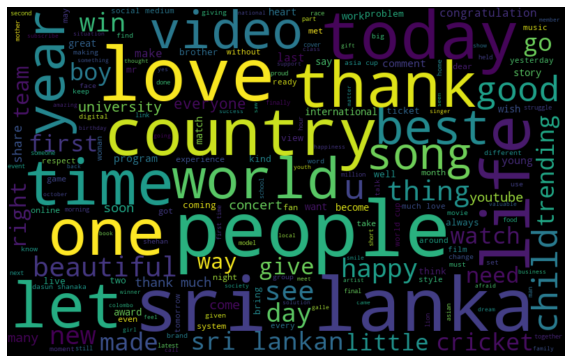

In [ ]:
words = ' '.join([sent for sent in df2[df2.Impact == 1].clean_tweet])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Word cloud for negative tweets

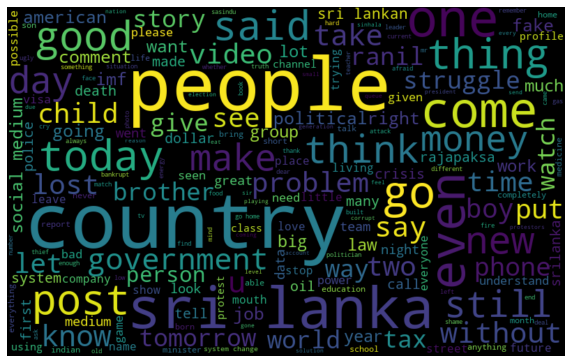

In [ ]:
words = ' '.join([sent for sent in df2[df2.Impact == 0].clean_tweet])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### **Word Embedding**

Word embedding is a technique where each word is represented by a vector. Words that have the similar meaning have a similar representation.

Keras provides a word Embedding layer which will be commonly used for text data in deep learning. Before, input data into the keras layer, we have to do some additional steps as follows
*   Integer encode
*   Add paddings



First, we define the vocabluary size for the texts. Then, each unique word is  assigned with an integer within that vocabluary size. For this, **tf.keras.preprocessing.text** provides **one_hot** function 

In [ ]:
#  create onehot 
voc_size = 5000
onehot_repr = [one_hot(sentence, voc_size) for sentence in final_corpus]

In [ ]:
# check the maximum length of oneHot encoded sentences
max_len = 0
for i in range(0, len(onehot_repr)):
  if len(onehot_repr[i])>max_len:
    max_len = len(onehot_repr[i])

max_len

46

To get all sentences to the same length, we can add padding at the beginning or end of words. For this, **tf.keras.preprocessing.sequence** provides **pad_sequences** function.

In [ ]:
# padding
sent_length = 50
padded_docs = pad_sequences(onehot_repr, padding='post', maxlen=sent_length)
padded_docs[:3]

array([[2271,  709, 3126,  362, 4062, 3539, 3081, 3951, 2271, 2665, 4966,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [4750, 2533, 2988,  892, 1454,  205, 4258, 1454, 2595,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 414,   44, 2145,  203, 3526, 3526, 4773, 1295, 1533, 3526, 4985,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

### **Build the model**


Use a LSTM model, 
1.   Embedding layer - we use a 30 length vector for represent one word. 
2.   Drop out layer - this is a regularization technique to avoid overfitting neural networks. This randomly drops neurons from the network during training in each iteration.
3.   LSTM layer with 128 neurons
4.   Fully connected dense layer with relu activation function
5.   Output layer - has one neuron with sigmoid activation function as this is a binary classification.


In [ ]:
# MODEL
embedded_vector_size = 30

model = Sequential()
model.add(Embedding(voc_size, embedded_vector_size, input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(128, dropout = 0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 30)            150000    
                                                                 
 dropout (Dropout)           (None, 50, 30)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               81408     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 239,729
Trainable params: 239,729
Non-trainable params: 0
_________________________________________________________________


#### Split data for training and testing

In [ ]:
X_train, X_test, y_trian, y_test = train_test_split(padded_docs, df2.Impact, test_size=0.2, stratify=df2.Impact,random_state=42)

#### Train the model using batch learning. 

In [ ]:
history = model.fit(X_train, y_trian, validation_split=0.2, epochs=200, batch_size=32)

Epoch 1/200
19/19 [==============================] - 6s 50ms/step - loss: 0.6947 - accuracy: 0.4840 - val_loss: 0.6940 - val_accuracy: 0.4497
Epoch 2/200
19/19 [==============================] - 0s 9ms/step - loss: 0.6934 - accuracy: 0.4890 - val_loss: 0.6942 - val_accuracy: 0.4497
Epoch 3/200
19/19 [==============================] - 0s 9ms/step - loss: 0.6935 - accuracy: 0.4941 - val_loss: 0.6933 - val_accuracy: 0.4497
Epoch 4/200
19/19 [==============================] - 0s 9ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6942 - val_accuracy: 0.4497
Epoch 5/200
19/19 [==============================] - 0s 9ms/step - loss: 0.6932 - accuracy: 0.5076 - val_loss: 0.6948 - val_accuracy: 0.4497
Epoch 6/200
19/19 [==============================] - 0s 9ms/step - loss: 0.6933 - accuracy: 0.5076 - val_loss: 0.6948 - val_accuracy: 0.4497
Epoch 7/200
19/19 [==============================] - 0s 9ms/step - loss: 0.6936 - accuracy: 0.5076 - val_loss: 0.6943 - val_accuracy: 0.4497
Epoch 8/200


### **Model evaluation**

Here is the training and testing accurcy. This model gives around 70% testing accuracy. But we can see, this is bit overfitting

In [ ]:
model.evaluate(X_test, y_test)[1] # test accuracy

6/6 [==============================] - 0s 4ms/step - loss: 0.8614 - accuracy: 0.7151


0.7150537371635437

In [ ]:
model.evaluate(X_train, y_trian)[1] # train accuracy

24/24 [==============================] - 0s 4ms/step - loss: 0.3764 - accuracy: 0.8787


0.8787062168121338

Below graphs shows the changes in training and testing accuracy throughout the training process.

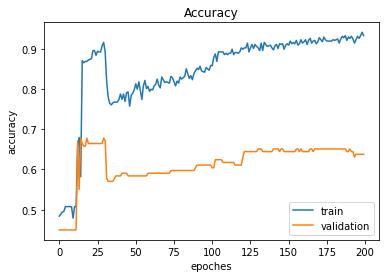

In [ ]:
# accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoches')
plt.title('Accuracy')
plt.legend(['train', 'validation'])
plt.show()

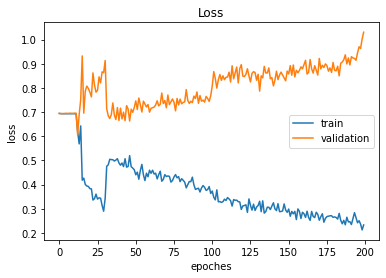

In [ ]:
#loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoches')
plt.title('Loss')
plt.legend(['train', 'validation'])
plt.show()

***Comments*** - According to the model results, eventhough this gives around 70% accurcy, it is overfitting. To avoid it, we can apply regularization techniques such as add dropout layers or else take more data. By hyperparameter tuning, we can try and achive high accuracy without overfitting. On the other hand, we can try early stopping approch to get better performance.

### **Predict the sentiment for a new tweet**


Here, The model returns the probability. We say that if the probability is larger than 0.5, it is a positive sentiment and otherwise, it is a negative sentiment.

In [ ]:
def predict_sentiment(tweet):
  voc_size = 5000
  sent_length = 50  #for padding
  
  text = clean_sinhText(tweet)
  text = convert_eng(text)
  sentence = final_cleanText(text)

  onehot_repr = [one_hot(sentence, voc_size)]
  padded_doc = pad_sequences(onehot_repr, padding='post', maxlen=sent_length)

  # prediction
  y_hat = model.predict(padded_doc)[0][0] 
  if y_hat > 0.5:
    sentiment = "Positive"
  else:
    sentiment = "Negative"

  return sentiment

In [ ]:
predict_sentiment("අපි අද Cricket match එක දිනනවා")

1/1 [==============================] - 0s 18ms/step


'Positive'

***comments*** - 
*   Above model performance and the correctness of the prediction depends on the 
dataset we used for training. Becuase these collected data can be subjective and also may depend on the time period we colleced the data.


***Future improvements -***
*   For the simplicity we removed the emojis and emoticons from tweets. But actually, those are playing a significant role in expressing the sentiments. If we can convert emojis to text(we can maintain a dictionary), sometimes it can give a correct sentiment more than text
*   Should more focus on stop words and stemming for sinhala words. For example, we used *token.is_stop* in spacy. But it is not working perfectly for sinhala language


